# IndoML 2023 Tuturial: Part 3
## The Era of LLMs!

### In-context learning and Prompt Engineering


1. We will use recent LLMs like GPT-3/FLAN-T5/LLAMA to query the models in natural language to get answers/predictions.
2. These models are finetuned on instructions or human-feedbacks to enable them to perform a task through "prompting".
3. Best part is we wouldn't need to train our models to get started, direct inference from these pretrained models is fine.
    * NOTE: Although there can be methods to finetune these models on our data to get better results, we will not be covering that in this tutorial.

### Models that we will try:

1. BLOOMZ by bigscience

## Load `dataset`

In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

tqdm.pandas()

dataset = load_dataset("AmazonScience/massive")


/nlsasfs/home/ttbhashini/arroy/anaconda3/envs/py38-new/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load `AutoTokenizer` and `AutoModelForSeq2SeqLM`

In [3]:
# pip install -q transformers accelerate bitsandbytes
from transformers import AutoTokenizer, AutoModelForCausalLM

# checkpoint = "bigscience/mt0-base"
checkpoint = "bigscience/bloomz-3b"
# checkpoint = "google/flan-t5-xxl"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto", load_in_4bit=True)

## Model Specific Example of Prompt Engineering

In [4]:
inputs = tokenizer.encode("Detect the intent class of the utterance.\nUtterance: I am going to school.; Intent:", return_tensors="pt").to("cuda")
outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0]))

/nlsasfs/home/ttbhashini/arroy/anaconda3/envs/py38-new/lib/python3.8/site-packages/transformers/generation/utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/nlsasfs/home/ttbhashini/arroy/anaconda3/envs/py38-new/lib/python3.8/site-packages/transformers/generation/utils.py:1262: UserWarning: Input length of input_ids is 22, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Detect the intent class of the utterance.
Utterance: I am going to school.; Intent: go


## Preprocessing

- We will create prompts for each test sample in the dataset. 
- There are few ways to format these prompt and this step is called "Prompt Engineering".
    - Few-shot In-context learning: Use task-description and examples
    - Zero-shot In-context learning: Use task-description only

## Exemplars for the multilingual intent-detection task

In [5]:
# Gather examples from the training dataset
import pandas as pd
df_train = dataset['train'].to_pandas()

# Extract one random sample per intent, we will randomly sample the rows
# Hope is that the model will predict english labels for any language that way.
df_intent_samples = df_train.groupby("intent").apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)    

In [6]:
# Add formatted prompt for each sample
def int2str(x):
    return dataset['train'].features['intent'].int2str(x)

df_intent_samples['example_prompt_format'] = df_intent_samples.apply(lambda x: f'Utterance: {x["utt"]}; Intent: {int2str(x["intent"])}', axis=1)

# merge examples into a single string
prompt_exemplars = df_intent_samples['example_prompt_format'].str.cat(sep='\n')

In [7]:
print(prompt_exemplars)

Utterance: የዛሬውን ቀን ልትነግሩኝ ትችላላቹ; Intent: datetime_query
Utterance: cambia las luces a azul; Intent: iot_hue_lightchange
Utterance: je veux un billet de train pour l' oregon; Intent: transport_ticket
Utterance: உணவகத்தில் எடுத்துச் செல்லும் வசதி உள்ளதா; Intent: takeaway_query
Utterance: berapakah nilai saham apple; Intent: qa_stock
Utterance: buna; Intent: general_greet
Utterance: olly ni matukio yapi yanafanyika karibu na mimi leo; Intent: recommendation_events
Utterance: bu mahnını xoşlamadığımı yadda saxla; Intent: music_dislikeness
Utterance: oprește-mi priza wemo acum; Intent: iot_wemo_off
Utterance: hvor mange grøntsager burde jeg spise om dagen; Intent: cooking_recipe
Utterance: இந்திய ரூபாவுடன் டாலரின் மாற்று விகிதம் என்ன; Intent: qa_currency
Utterance: 運輸; Intent: transport_traffic
Utterance: چطور پیش می‌رود; Intent: general_quirky
Utterance: آج آب و ہوا کیسی ہے; Intent: weather_query
Utterance: volumen på musikken der spiller nu skal op; Intent: audio_volume_up
Utterance: እባክ

## Generate prompts for each query

In [8]:
# Add a new feature column to the dataset
# Prompt: What is the intent of the following sentence?\m "{utt}"

few_shot = True
def add_prompt(example):
    if few_shot:
        example["prompt"] = f'# Detect intent of the input utterance.\n\n{prompt_exemplars}\nUtterance: {example["utt"]}; Intent:'
    else:
        example["prompt"] = f'# Detect intent of the input utterance.\n\nUtterance: {example["utt"]}; Intent:'
    
    example["str_label"] = int2str(example["intent"])
    return example


extended_eval_set = dataset['validation'].map(add_prompt)

Map: 100%|██████████| 103683/103683 [02:07<00:00, 813.39 examples/s] 


In [9]:
extended_eval_set[0]

{'id': '11',
 'locale': 'mn-MN',
 'partition': 'dev',
 'scenario': 8,
 'intent': 40,
 'utt': 'гэрлийг унтраа',
 'annot_utt': 'гэрлийг унтраа',
 'worker_id': '5',
 'slot_method': {'slot': [], 'method': []},
 'judgments': {'worker_id': ['43', '4', '30'],
  'intent_score': [1, 1, 1],
  'slots_score': [1, 1, 1],
  'grammar_score': [4, 3, 4],
  'spelling_score': [2, 2, 2],
  'language_identification': ['target', 'target', 'target']},
 'prompt': "# Detect intent of the input utterance.\n\nUtterance: የዛሬውን ቀን ልትነግሩኝ ትችላላቹ; Intent: datetime_query\nUtterance: cambia las luces a azul; Intent: iot_hue_lightchange\nUtterance: je veux un billet de train pour l' oregon; Intent: transport_ticket\nUtterance: உணவகத்தில் எடுத்துச் செல்லும் வசதி உள்ளதா; Intent: takeaway_query\nUtterance: berapakah nilai saham apple; Intent: qa_stock\nUtterance: buna; Intent: general_greet\nUtterance: olly ni matukio yapi yanafanyika karibu na mimi leo; Intent: recommendation_events\nUtterance: bu mahnını xoşlamadığımı ya

## Now let's try to predict using the LLM

In [10]:
print(extended_eval_set[100]['prompt'])

x = extended_eval_set[100]['prompt']
tok_x = tokenizer(x, return_tensors="pt")
y = model.generate(tok_x['input_ids'].to("cuda"), num_beams=5, num_return_sequences=5, max_length=2000)
output = tokenizer.decode(y[0], skip_special_tokens=True)
print(output)

# Detect intent of the input utterance.

Utterance: የዛሬውን ቀን ልትነግሩኝ ትችላላቹ; Intent: datetime_query
Utterance: cambia las luces a azul; Intent: iot_hue_lightchange
Utterance: je veux un billet de train pour l' oregon; Intent: transport_ticket
Utterance: உணவகத்தில் எடுத்துச் செல்லும் வசதி உள்ளதா; Intent: takeaway_query
Utterance: berapakah nilai saham apple; Intent: qa_stock
Utterance: buna; Intent: general_greet
Utterance: olly ni matukio yapi yanafanyika karibu na mimi leo; Intent: recommendation_events
Utterance: bu mahnını xoşlamadığımı yadda saxla; Intent: music_dislikeness
Utterance: oprește-mi priza wemo acum; Intent: iot_wemo_off
Utterance: hvor mange grøntsager burde jeg spise om dagen; Intent: cooking_recipe
Utterance: இந்திய ரூபாவுடன் டாலரின் மாற்று விகிதம் என்ன; Intent: qa_currency
Utterance: 運輸; Intent: transport_traffic
Utterance: چطور پیش می‌رود; Intent: general_quirky
Utterance: آج آب و ہوا کیسی ہے; Intent: weather_query
Utterance: volumen på musikken der spiller nu skal o

In [11]:
N_class = dataset['train'].features['intent'].num_classes
str2int = {}
for i in range(N_class):
    str2int[int2str(i)] = i

def parse_prediction(prompt, output_txt):
    # take the diff between the prompt and the generated text
    # cut it till the first \n
    pred_class = output_txt[len(prompt):].split('\n')[0].strip()

    # Check if it matches any label in the dataset
    if pred_class in str2int:
        return str2int[pred_class], pred_class
    else:
        return -1, pred_class

In [12]:
sorted(list(str2int.keys()))

['alarm_query',
 'alarm_remove',
 'alarm_set',
 'audio_volume_down',
 'audio_volume_mute',
 'audio_volume_other',
 'audio_volume_up',
 'calendar_query',
 'calendar_remove',
 'calendar_set',
 'cooking_query',
 'cooking_recipe',
 'datetime_convert',
 'datetime_query',
 'email_addcontact',
 'email_query',
 'email_querycontact',
 'email_sendemail',
 'general_greet',
 'general_joke',
 'general_quirky',
 'iot_cleaning',
 'iot_coffee',
 'iot_hue_lightchange',
 'iot_hue_lightdim',
 'iot_hue_lightoff',
 'iot_hue_lighton',
 'iot_hue_lightup',
 'iot_wemo_off',
 'iot_wemo_on',
 'lists_createoradd',
 'lists_query',
 'lists_remove',
 'music_dislikeness',
 'music_likeness',
 'music_query',
 'music_settings',
 'news_query',
 'play_audiobook',
 'play_game',
 'play_music',
 'play_podcasts',
 'play_radio',
 'qa_currency',
 'qa_definition',
 'qa_factoid',
 'qa_maths',
 'qa_stock',
 'recommendation_events',
 'recommendation_locations',
 'recommendation_movies',
 'social_post',
 'social_query',
 'takeaway_o

In [13]:
parse_prediction(x, output)

(-1, 'food_query')

## Setup Evaluation Metric

In [14]:
import numpy as np
import evaluate

metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

# We need to define a compute_metric function that is supported by the Trainer output
# It basically converts the logits to predictions and then calls the metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # print("Predictions: ", predictions)
    # print("Labels: ", labels)
    return metric_f1.compute(predictions=predictions, references=labels, average="macro")

## Select a smaller subset for evaluation

In [15]:
import random
# Select random samples from above subsets
n_eval = 600
eval_indices = random.sample(range(len(extended_eval_set)), n_eval)

In [16]:
eval_data_subset = extended_eval_set.select(eval_indices)

In [17]:
# Gather prediction for the eval set
outputs = []
for i in tqdm(range(len(eval_data_subset))):
    x = eval_data_subset[i]['prompt']
    tok_x = tokenizer(x, return_tensors="pt")
    y = model.generate(tok_x['input_ids'].to("cuda"), num_beams=3, num_return_sequences=3, max_length=2000)
    all_predictions = []
    for j in range(len(y)):
        output = tokenizer.decode(y[j], skip_special_tokens=True)
        all_predictions.append(output)
    outputs.append(all_predictions)

100%|██████████| 600/600 [52:39<00:00,  5.27s/it]  


In [18]:
# Parse the predictions
parsed_predictions = []
for i in tqdm(range(len(eval_data_subset))):
    x = eval_data_subset[i]['prompt']
    all_predictions = outputs[i]
    parsed_predictions.append([parse_prediction(x, output) for output in all_predictions])

100%|██████████| 600/600 [00:29<00:00, 20.58it/s]


In [19]:
parsed_predictions

[[(-1, 'travel_query'), (-1, 'travel_guide'), (42, 'transport_query')],
 [(-1, 'travel_query'), (-1, 'travel_ticket'), (-1, 'travel_rental')],
 [(-1, 'travel_query'), (21, 'lists_createoradd'), (-1, 'travel_guide')],
 [(11, 'transport_traffic'), (-1, 'travel_query'), (-1, 'travel_traffic')],
 [(-1, 'travel_query'), (-1, 'travel_traffic'), (-1, 'travel_list')],
 [(32, 'calendar_query'), (-1, 'time_query'), (-1, 'travel_time')],
 [(32, 'calendar_query'),
  (50, 'calendar_set'),
  (-1, 'calendar_query_calendar')],
 [(-1, 'travel_query'), (21, 'lists_createoradd'), (59, 'lists_query')],
 [(-1, 'travel_query'), (-1, 'travel_guide'), (-1, 'travel_rides')],
 [(-1, 'travel_query'), (-1, 'travel_guide'), (-1, 'travel_traffic')],
 [(-1, 'name_query'), (-1, 'entertainment_query'), (17, 'email_querycontact')],
 [(-1, 'travel_query'), (58, 'play_podcasts'), (-1, 'play_podcast')],
 [(-1, 'travel_query'), (-1, 'travel_ticket'), (-1, 'travel_guide')],
 [(33, 'email_sendemail'), (44, 'email_query'), (-

In [25]:
selected_predictions = [x[1] for x in parsed_predictions]

In [28]:
df_eval = eval_data_subset.to_pandas()
df_eval['pred_label_str'] = [x[1] for x in selected_predictions]
df_eval['pred_label_int'] = [x[0] for x in selected_predictions]

In [29]:
df_eval

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id,slot_method,judgments,prompt,str_label,pred_label_str,pred_label_int
0,15786,hy-AM,dev,7,44,աննայից որևէ մեյլ կա,[person : աննայից] որևէ մեյլ կա,11,"{'slot': ['person'], 'method': ['unchanged']}","{'worker_id': ['41', '9', '15'], 'intent_score...",# Detect intent of the input utterance.\n\nUtt...,email_query,travel_guide,-1
1,1380,ja-JP,dev,14,3,すしざんまいの配達を注文できるか,[business_name : すしざんまい] の [order_type : 配達] を...,11,"{'slot': ['order_type', 'business_name'], 'met...","{'worker_id': ['16', '0', '9'], 'intent_score'...",# Detect intent of the input utterance.\n\nUtt...,takeaway_query,travel_ticket,-1
2,16303,pl-PL,dev,7,44,czy możesz sprawdzić czy mam jakieś powiadomienia,czy możesz sprawdzić czy mam jakieś powiadomienia,7,"{'slot': [], 'method': []}","{'worker_id': ['21', '11', '5'], 'intent_score...",# Detect intent of the input utterance.\n\nUtt...,email_query,lists_createoradd,21
3,13587,he-IL,dev,12,26,הגדרת מסגרת,הגדרת [definition_word : מסגרת],0,"{'slot': ['definition_word'], 'method': ['tran...","{'worker_id': ['0', '21', '16'], 'intent_score...",# Detect intent of the input utterance.\n\nUtt...,qa_definition,travel_query,-1
4,10806,da-DK,dev,11,59,vis mig mine lister tak,vis mig mine lister tak,6,"{'slot': [], 'method': []}","{'worker_id': ['17', '6', '9'], 'intent_score'...",# Detect intent of the input utterance.\n\nUtt...,lists_query,travel_traffic,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,657,es-ES,dev,17,13,como es el estado del tiempo ahora,como es el estado del tiempo ahora,18,"{'slot': [], 'method': []}","{'worker_id': ['16', '7', '4'], 'intent_score'...",# Detect intent of the input utterance.\n\nUtt...,weather_query,datetime_query,0
596,16081,ms-MY,dev,7,33,hantar emel kepada pengurus saya,hantar emel kepada [relation : pengurus] saya,12,"{'slot': ['relation'], 'method': ['translation']}","{'worker_id': ['1', '9', '12'], 'intent_score'...",# Detect intent of the input utterance.\n\nUtt...,email_sendemail,email_sendemail,33
597,2993,sq-AL,dev,3,45,luaj këngën e radhës,luaj këngën e radhës,2,"{'slot': [], 'method': []}","{'worker_id': ['3', '2', '27'], 'intent_score'...",# Detect intent of the input utterance.\n\nUtt...,play_music,travel_guide,-1
598,12505,zh-CN,dev,1,42,北京运通火车,[place_name : 北京] 运通 [transport_type : 火车],29,"{'slot': ['transport_type', 'place_name'], 'me...","{'worker_id': ['10', '36', '26'], 'intent_scor...",# Detect intent of the input utterance.\n\nUtt...,transport_query,transport_traffic,11


## Analyze the performance of the model

In [21]:
# Compute f1 for each locale and plot f1 scores vs locales
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 8)}) # Setting some matplotlib configs



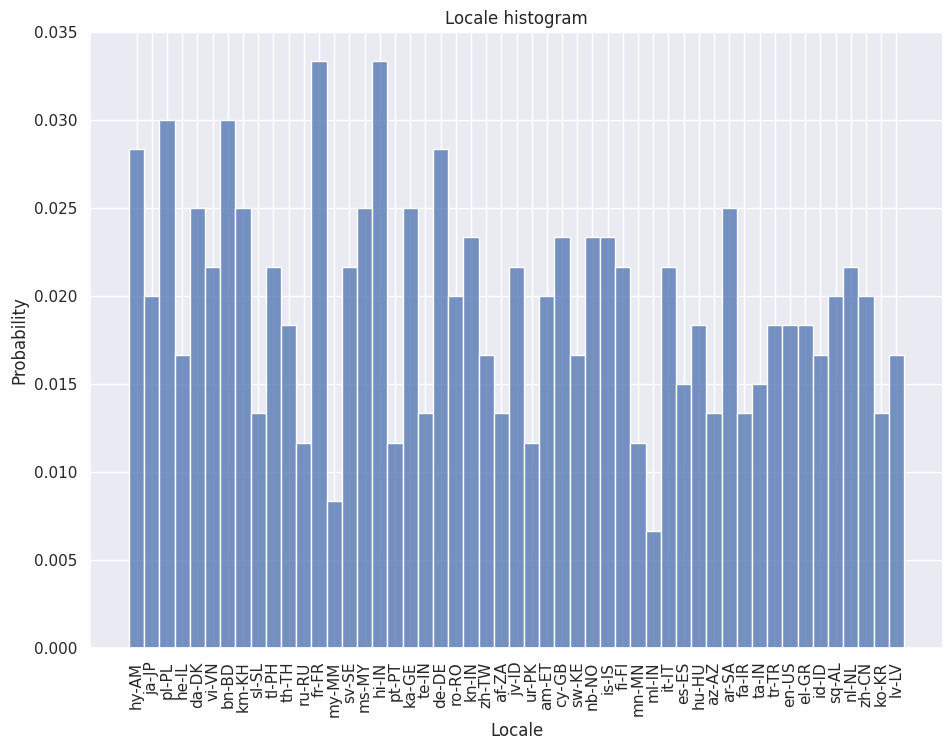

In [22]:
# Print histogram of locale, y-axis normalized to 1
P = sns.histplot(df_eval['locale'], stat="probability")

P.set_xlabel("Locale")
P.set_ylabel("Probability")
P.set_title("Locale histogram")

# Rotate x labels by 90 degrees
for item in P.get_xticklabels():
    item.set_rotation(90)



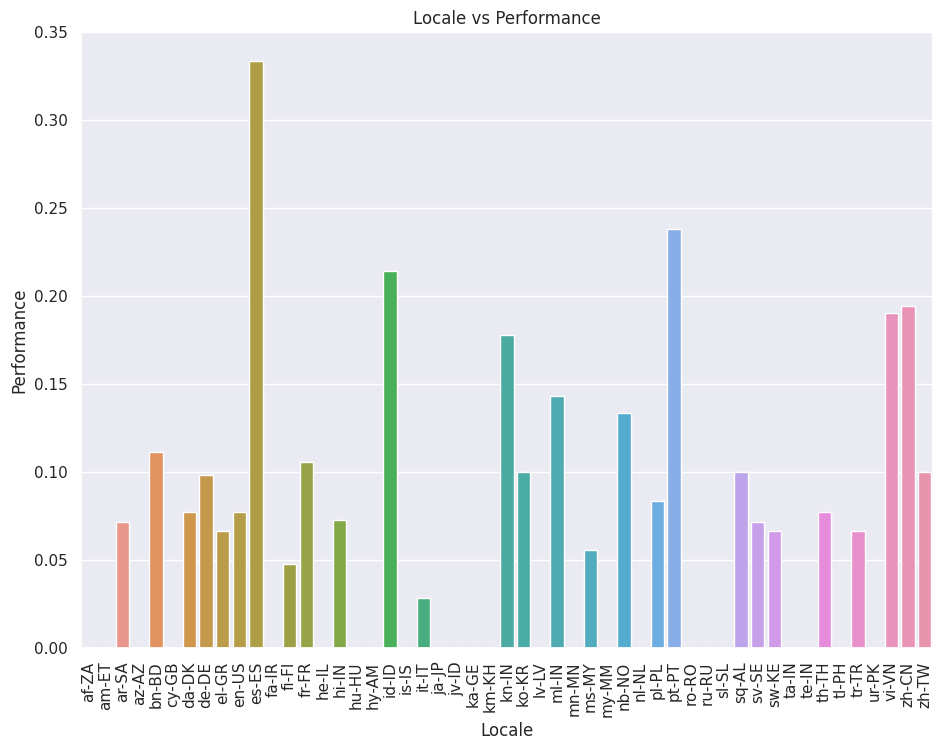

In [31]:
def compute_f1(df):
    return f1_score(df['intent'], df['pred_label_int'], average='macro')

def compute_acc(df):
    return accuracy_score(df['intent'], df['pred_label_int'])

df_f1 = df_eval.groupby('locale').apply(compute_f1)
P = sns.barplot(x=df_f1.index, y=df_f1.values)
# df_acc = df.groupby('locale').apply(compute_acc)
# P = sns.barplot(x=df_acc.index, y=df_acc.values)

P.set_title("Locale vs Performance")
P.set_xlabel("Locale")
P.set_ylabel("Performance")

# Rotate x labels by 90 degrees
for item in P.get_xticklabels():
    item.set_rotation(90)

